In [ ]:
!pip install llama-index
!pip install llama-index-vector-stores-qdrant llama-index-embeddings-fastembed
!pip install llama-index-readers-file
!pip install llama-index-llms-groq  # deepseek r1

^C
^C


In [ ]:
import logging
import sys
import os

In [ ]:
import qdrant_client
from qdrant_client import models
from llama_index.core import SimpleDirectoryReader
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.llms.groq import Groq # deep seek r1 implementation

## Load the source documents - Bhagavad Gita PDF

In [ ]:
data = SimpleDirectoryReader("data").load_data()

In [ ]:
len(data)

In [ ]:
data[100].text

In [ ]:
texts = [doc.text for doc in data]

In [ ]:
texts[100]

In [ ]:
len(texts)

In [ ]:
from google.colab import userdata

In [ ]:
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")

In [ ]:
llm = Groq(model="deepseek-r1-distill-llama-70b")

In [ ]:
llm.complete("what is the meaning of life?").text

In [ ]:
embed_model = FastEmbedEmbedding(model_name="thenlper/gte-large")

In [ ]:
client = qdrant_client.QdrantClient(
    #location=":memory:",
    url = userdata.get("QDRANT_URL"),
    api_key = userdata.get("QDRANT_API_KEY"),
    prefer_grpc=True
)

In [ ]:
collection_name = "bhagavad-gita"

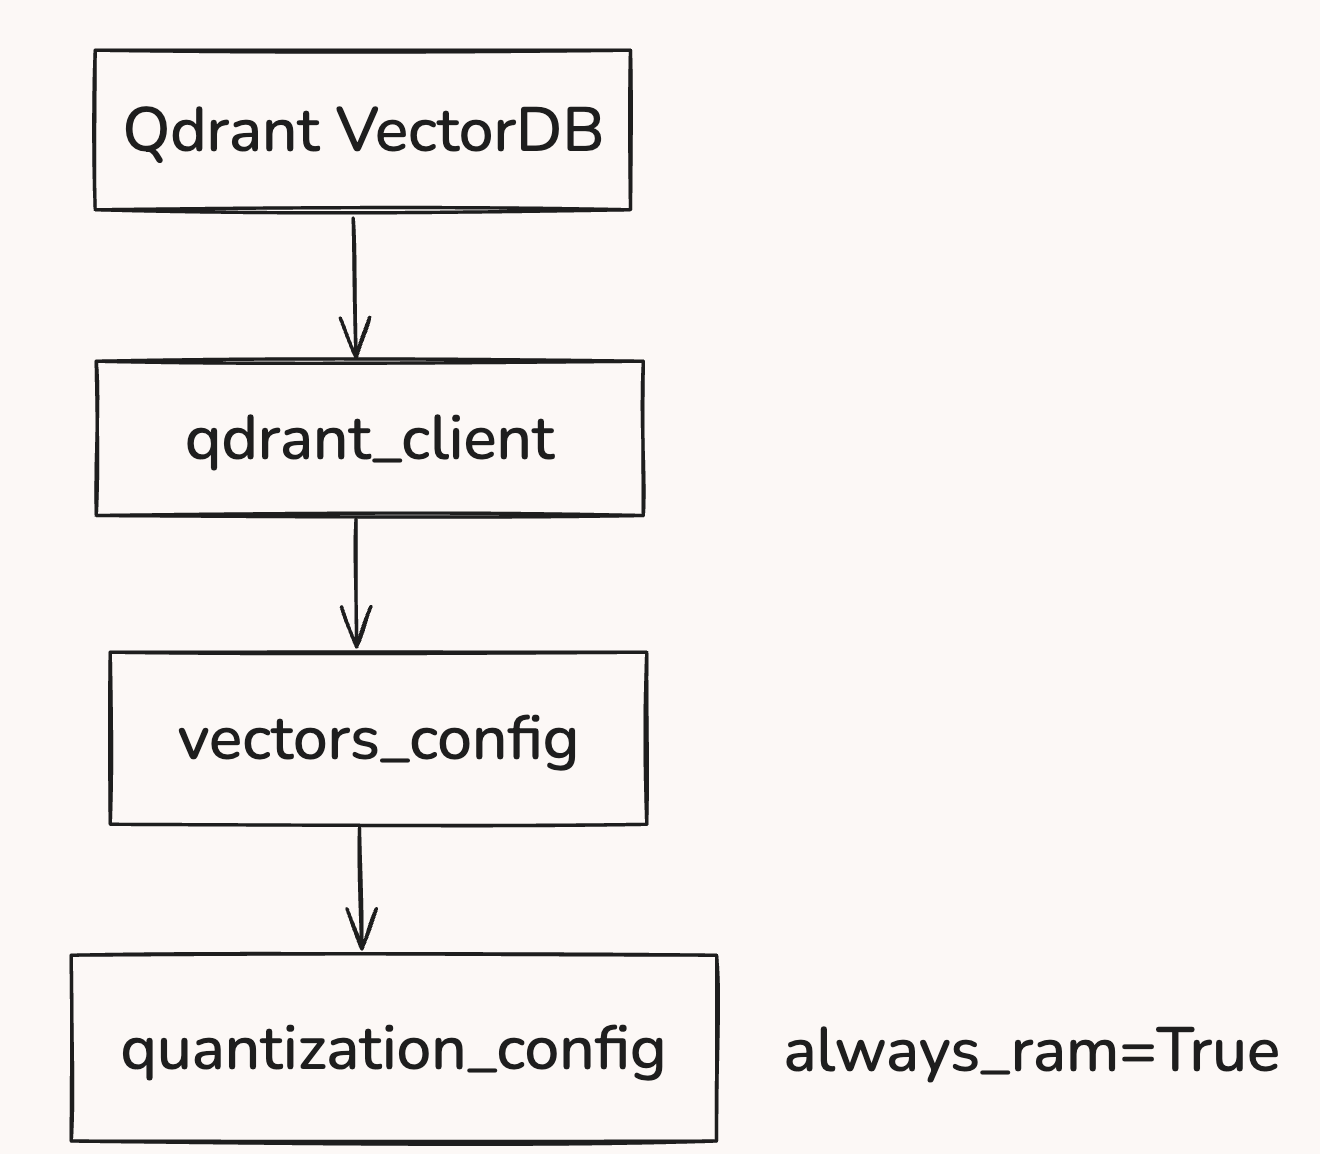

In [ ]:
if not client.collection_exists(collection_name=collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=1024,
                                           distance=models.Distance.COSINE,on_disk=True),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True,
            ),
        ),
    )
else:
    print("Collection already exists")

In [ ]:
embeddings = []
BATCH_SIZE = 50

In [ ]:
for page in range(0, len(texts), BATCH_SIZE):
    page_content = texts[page:page + BATCH_SIZE]
    response = embed_model.get_text_embedding_batch(page_content)
    embeddings.extend(response)

In [ ]:
for idx in range(0, len(texts), BATCH_SIZE):
    docs = texts[idx:idx + BATCH_SIZE]
    embeds = embeddings[idx:idx + BATCH_SIZE]

    client.upload_collection(collection_name=collection_name,
                                vectors=embeds,
                                payload=[{"context": context} for context in docs])

In [ ]:
client.update_collection(collection_name= collection_name,
                        optimizer_config=models.OptimizersConfigDiff(indexing_threshold=20000))

## Retrieval Augmented Generation

In [ ]:
def search(query,k=5):
  # query = user prompt
  query_embedding = embed_model.get_query_embedding(query)
  result = client.query_points(
            collection_name = collection_name,
            query=query_embedding,
            limit = k
        )
  return result

In [ ]:
relevant_docs = search("In Bhagavad-gītā who is the person devoted to?")

In [ ]:
len(relevant_docs.points)

In [ ]:
print(relevant_docs.points[4].payload['context'])

In [ ]:
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

message_templates = [
    ChatMessage(
        content="""
        You are an expert ancient assistant who is well verse in Bhagavad-gita.
        You are Multilingual, you understand English, Hindi and Sanskrit.
        """,
        role=MessageRole.SYSTEM),
    ChatMessage(
        content="""
        We have provided context information below.
        {context_str}
        ---------------------
        Given this information, please answer the question: {query}
        ---------------------
        If the question is not from the provided context, say `I don't know. Not enough information recieved.`
        """,
        role=MessageRole.USER,
    ),
]

In [ ]:
def pipeline(query):
    # R - Retriver
    relevant_documents = search(query)
    context = [doc.payload['context'] for doc in relevant_documents.points]
    context = "\n".join(context)

    # A - Augment
    chat_template = ChatPromptTemplate(message_templates=message_templates)

    # G - Generate
    response = llm.complete(
        chat_template.format(
            context_str=context,
            query=query)
    )
    return response

In [ ]:
print(pipeline("""what is the PURPORT of O	 my	 teacher,	 behold	 the	 great	 army	 of	 the	 sons	 of	 Pāṇḍu,	 so
expertly	arranged	by	your	intelligent	disciple,	the	son	of	Drupada."""))

In [ ]:
print(pipeline("""
Jayas	tu	pāṇḍu-putrāṇāṁ	yeṣāṁ	pakṣe	janārdanaḥ.
explain this gita from translation
"""))